In [13]:
import sys
sys.path.insert(0, '/home/student.unimelb.edu.au/shorte1/Documents/TINT')

import sys
sys.path.insert(0, '/home/563/esh563/TINT')

# Core
import datetime
import os
import glob
import tempfile
import pickle
import copy

# Analysis
import numpy as np
import pandas as pd
import xarray as xr

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams

# Debugging
import pdb, traceback
# %load_ext line_profiler

# Radar Tools
import pyart
import tint
# import tint.animate
# from tint.visualisation import animate

import CPOL_func as cf
import classification as cl
import caine_func as caf
import analysis
import boring_stats as bs
import two_dimensional_analysis as td

# Convenience functions
%load_ext autoreload
%autoreload 1
%aimport CPOL_func
%aimport caine_func
%aimport classification
%aimport tint.visualisation.figures
%aimport tint.visualisation.animate
%aimport tint.visualisation.horizontal_helpers
%aimport tint.visualisation.vertical_helpers
%aimport tint.tracks
%aimport tint.objects
%aimport tint.grid_utils
%aimport tint.steiner
%aimport tint.matching
%aimport tint.rain
%aimport tint.cells
%aimport tint.tracks_helpers
%aimport tint.process_ERA5
%aimport tint.process_WRF
%aimport boring_stats
%aimport two_dimensional_analysis

%pdb

base_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/CPOL/'
save_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_tracks/ACCESS_radar_base/'
fig_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures/ACCESS_radar_base/'
ERA5_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/era5/'
ERA5_dir += 'pressure-levels/reanalysis/'
WRF_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/caine_WRF_data/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Automatic pdb calling has been turned OFF


In [2]:
test_names = [
    'base', 'ambient_swapped', 'ambient_swapped_lower_wind_level', 
    'lower_wind_level', 'higher_wind_level',
    'no_steiner', 'lower_ref_thresh',
    'higher_offset_thresh', 'higher_border_thresh',
    'higher_area_thresh', 'higher_conv_area_thresh', 'linear_50', 'linear_25', 
    'combined_sensitivity']

In [75]:
class_thresh_base = {
    'OFFSET_MAG': 10000,  # metres
    'SHEAR_MAG': 2,  # m/s
    'VEL_MAG': 5,  # m/s
    'REL_VEL_MAG': 2,  # m/s
    'ANGLE_BUFFER': 10}

excl_thresh_base = {
    'SMALL_AREA': 500,  # km^2
    'LARGE_AREA': 50000,  # km^2
    'BORD_THRESH': 0.001,  # Ratio border pixels to total pixels
    'MAJOR_AXIS_LENGTH': 25,  # km
    'AXIS_RATIO': 2,
    'DURATION': 30}  # minutes

test_names = [
    'base', 'ambient_swapped', 'ambient_swapped_lower_wind_level', 
    'lower_wind_level', 'higher_wind_level', 'no_steiner', 
    'lower_ref_thresh', 'higher_offset_thresh', 'higher_border_thresh',
    'higher_area_thresh', 'higher_conv_area_thresh', 'linear_50', 
    'linear_25', 'combined_sensitivity']

tracks_dir = [
    'base', 'ambient_swapped', 'ambient_swapped_lower_wind_level',
    'lower_wind_level', 'higher_wind_level', 'no_steiner', 
    'lower_ref_thresh', 'base', 'base',
    'base', 'base', 'base',
    'base', 'base']

[
    class_thresh_SO15] = [
    copy.deepcopy(class_thresh_base) for i in range(1)]

class_thresh_SO15['OFFSET_MAG'] = 15000

class_thresh_comb = {
    'OFFSET_MAG': 12500,
    'SHEAR_MAG': 3,
    'VEL_MAG': 5,
    'REL_VEL_MAG': 3,
    'ANGLE_BUFFER': 15}

class_threshes = [
    None, None, None, 
    None, None, None,
    None, class_thresh_SO15, None, 
    None, None, None, 
    None, class_thresh_comb]

[
    excl_thresh_B05, excl_thresh_A2000, excl_thresh_CA240,
    excl_thresh_L50, excl_thresh_L25] = [
    copy.deepcopy(excl_thresh_base) for i in range(5)]

excl_thresh_B05['BORD_THRESH'] = 0.0005
excl_thresh_A2000['SMALL_AREA'] = 2000
excl_thresh_CA240['SMALL_AREA'] = 240
excl_thresh_L50['MAJOR_AXIS_LENGTH'] = 50
excl_thresh_L25['MAJOR_AXIS_LENGTH'] = 25

excl_thresh_comb = {
    'SMALL_AREA': 2000,
    'LARGE_AREA': 50000,
    'BORD_THRESH': 0.001,
    'MAJOR_AXIS_LENGTH': 25,
    'AXIS_RATIO': 2,
    'DURATION': 30}

# test_names = [
#     'base', 'ambient_swapped', 'ambient_swapped_lower_wind_level', 
#     'lower_wind_level', 'higher_wind_level', 'no_steiner', 
#     'lower_ref_thresh', 'higher_offset_thresh', 'higher_border_thresh',
#     'higher_area_thresh', 'higher_conv_area_thresh', 'linear_50', 
#     'linear_25', 'combined_sensitivity']

excl_threshes = [
    None, None, None, 
    None, None, None,
    None, None, excl_thresh_B05, 
    excl_thresh_A2000, excl_thresh_CA240, excl_thresh_L50, 
    excl_thresh_L25, excl_thresh_comb]

non_linear_conds = [
    False, False, False, 
    False, False, False, 
    False, False, False, 
    False, False, True, 
    True, False]

# Define the restricted samples
exclusion_lists = [
    [
        'small_area', 'large_area', 'intersect_border',
        'intersect_border_convective', 'duration_cond',
        'small_velocity', 'small_offset'] for i in range(14)]

exclusion_lists[10] += ['small_conv_area']
exclusion_lists[11] += ['non_linear']
exclusion_lists[12] += ['non_linear']

# Generate Figures

Radar 42, year 2020.
Calculating system tracks.
Radar 42, year 2021.
Calculating system tracks.
Radar 63, year 2020.
Calculating system tracks.
Radar 63, year 2021.
Calculating system tracks.
Radar 77, year 2020.
Calculating system tracks.
Radar 77, year 2021.
Calculating system tracks.
Radar 42, year 2020.
Calculating system tracks.
Radar 42, year 2021.
Calculating system tracks.
Radar 63, year 2020.
Calculating system tracks.
Radar 63, year 2021.
Calculating system tracks.
Radar 77, year 2020.
Calculating system tracks.
Radar 77, year 2021.
Calculating system tracks.
Radar 42, year 2020.
Calculating system tracks.
Radar 42, year 2021.
Calculating system tracks.
Radar 63, year 2020.
Calculating system tracks.
Radar 63, year 2021.
Calculating system tracks.
Radar 77, year 2020.
Calculating system tracks.
Radar 77, year 2021.
Calculating system tracks.
Radar 42, year 2020.
Calculating system tracks.
Radar 42, year 2021.
Calculating system tracks.
Radar 63, year 2020.
Calculating system 

No included observations.
Radar 77, year 2020.
Calculating system tracks.
No included observations.
Calculating system tracks.
No included observations.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
No included observations.
Calculating system tracks.
No included observations.
Radar 77, year 2021.
Calculating system tracks.
No included observations.
Calculating system tracks.
No included observations.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
No included observations.
Calculating system tracks.
No included observations.
Radar 42, year 2020.
Calculating system tracks.
No included observations.
Calculating system tracks.
No included observations.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
No included observations.
Calculating system tracks.
No included observations.
Radar 42, year 2021.
Calculating

Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Radar 42, year 2020.
Calculating system tracks.
No included observations.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
No included observations.
Radar 42, year 2021.
Calculating system tracks.
Calculating system tracks.
No included observations.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Radar 63, year 2020.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Radar 63, year 2021.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
R

Calculating system tracks.
Calculating system tracks.
Radar 63, year 2020.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Radar 63, year 2021.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Radar 77, year 2020.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Radar 77, year 2021.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Radar 42, year 2020.
Calculating system tracks.
No included observations.
Calculating system tracks.
No in

Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Radar 77, year 2021.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Radar 42, year 2020.
Calculating system tracks.
Radar 42, year 2021.
Calculating system tracks.
Radar 63, year 2020.
Calculating system tracks.
Radar 63, year 2021.
Calculating system tracks.
Radar 77, year 2020.
Calculating system tracks.
Radar 77, year 2021.
Calculating system tracks.
Radar 42, year 2020.
Calculating system tracks.
Radar 42, year 2021.
Calculating system tracks.
Radar 63, year 2020.
Calculating system tracks.
Radar 63, year 2021.
Calculating system tracks.
Radar 77, year 2020.
Calculating system tracks.
Radar 77, year 2021.
Calculating system tracks.
Radar 42, year 2020.
Calculating system tracks.
Radar 42, year 2021.
Calculatin

/home/student.unimelb.edu.au/shorte1/Documents/CPOL_analysis/boring_stats.py:210: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(3, 2, figsize=(12, 7))


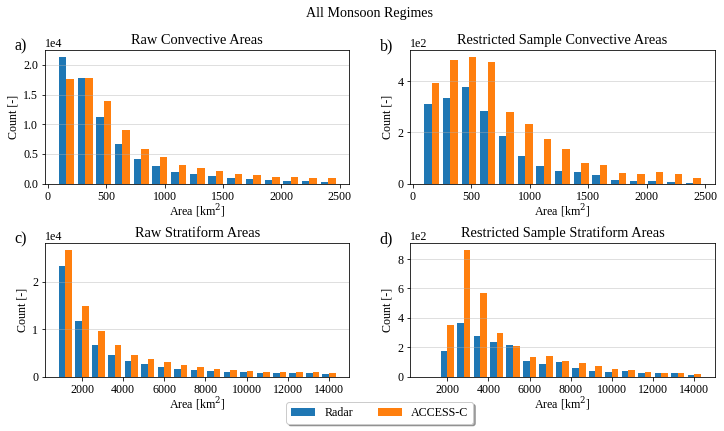

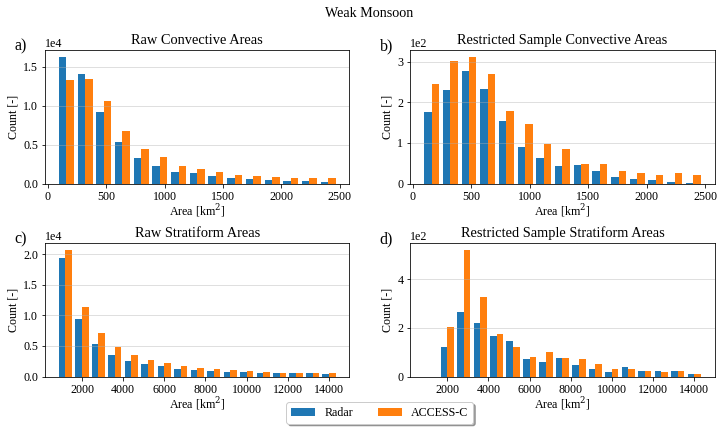

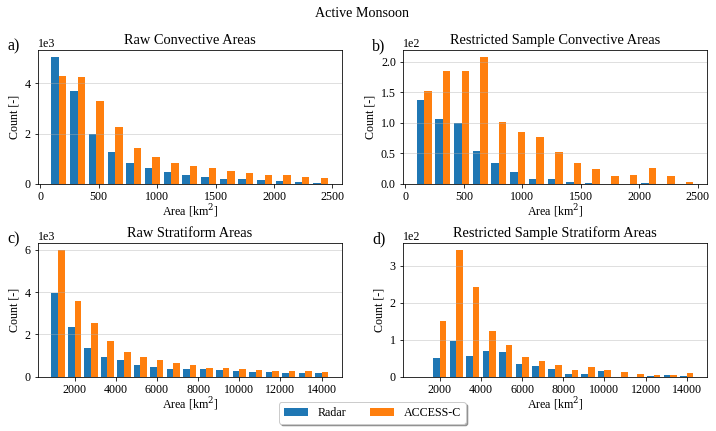

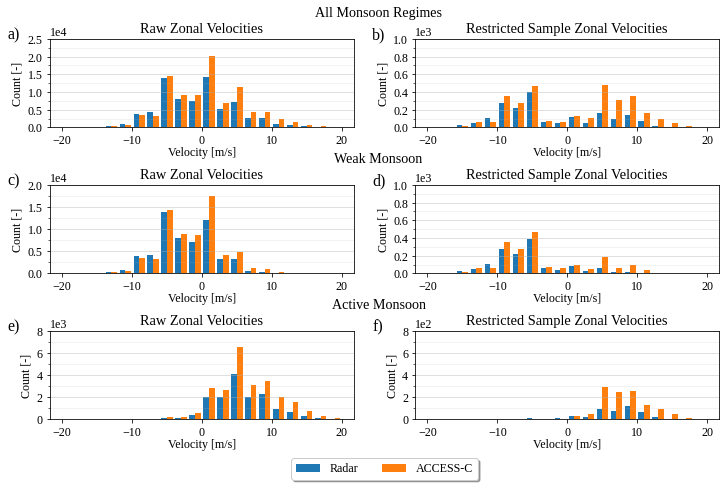

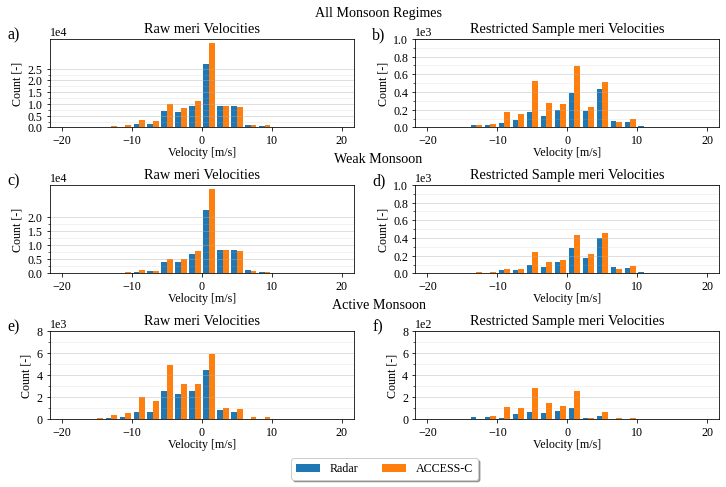

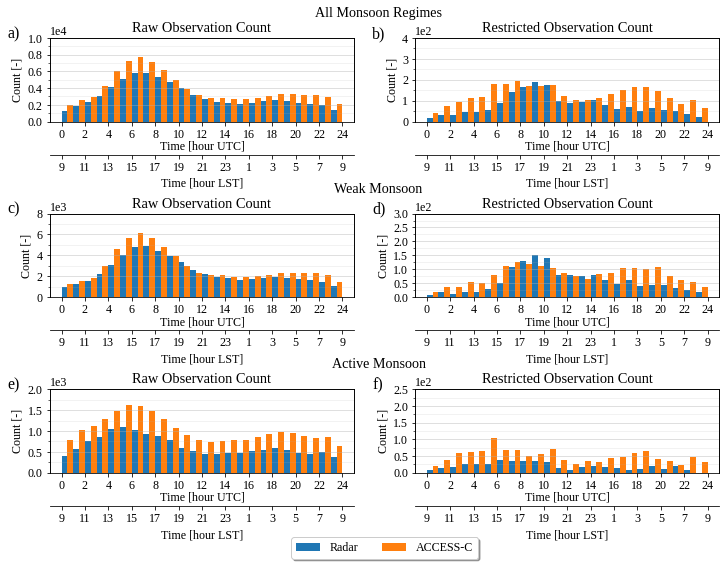

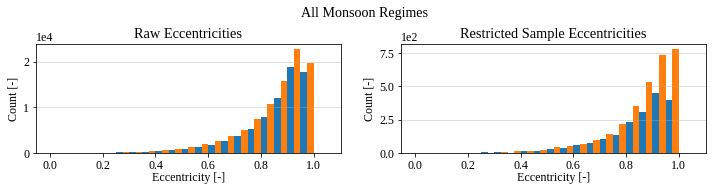

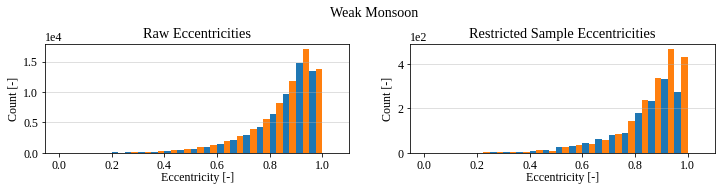

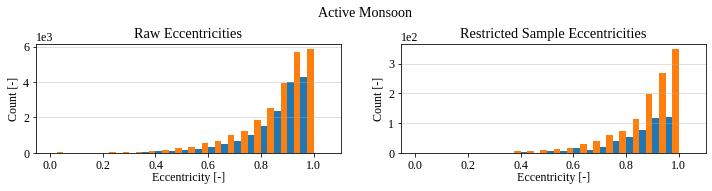

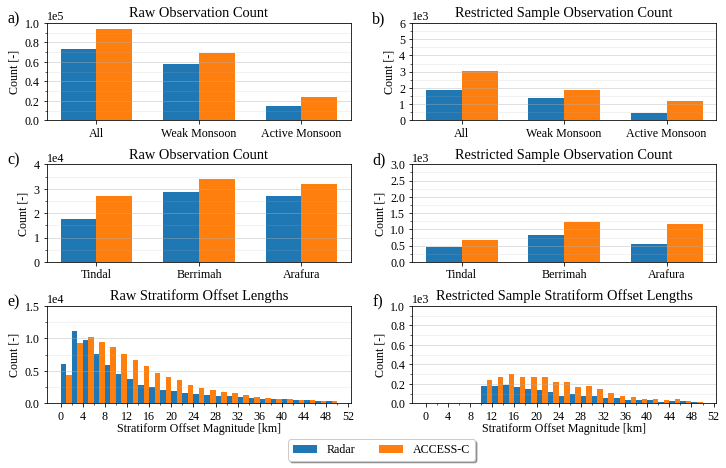

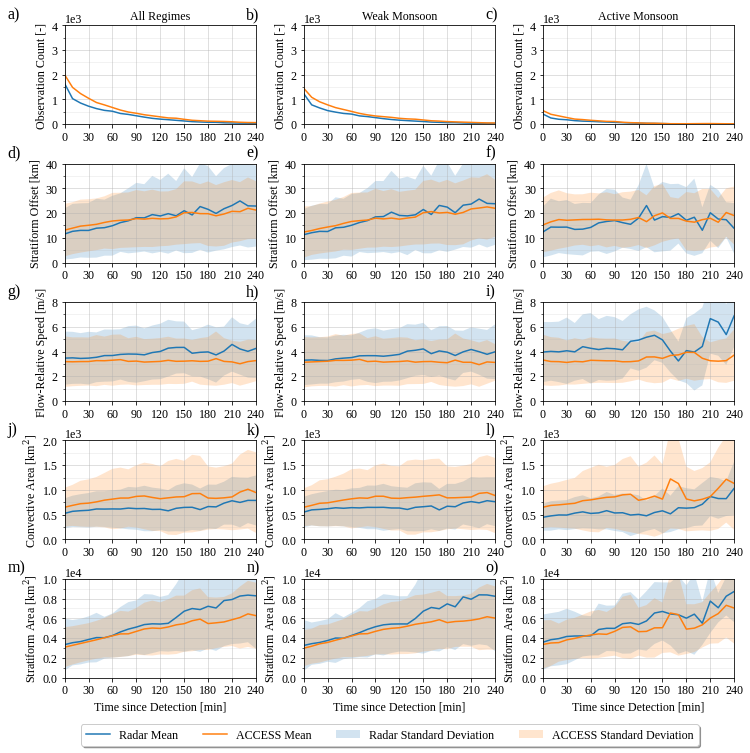

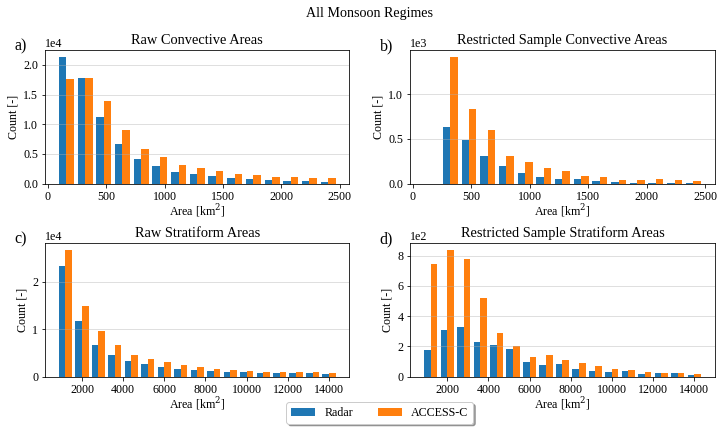

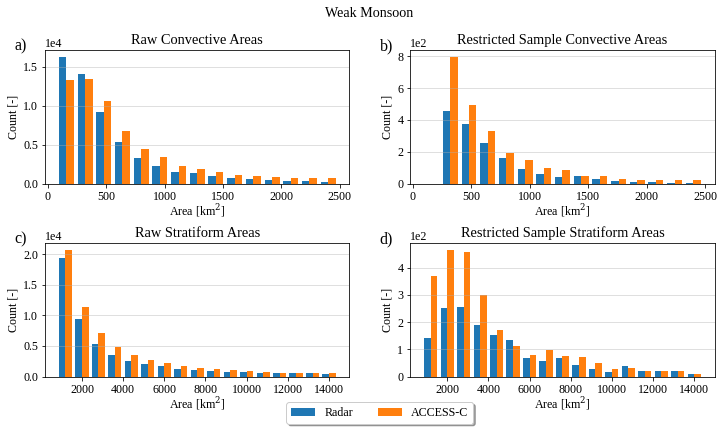

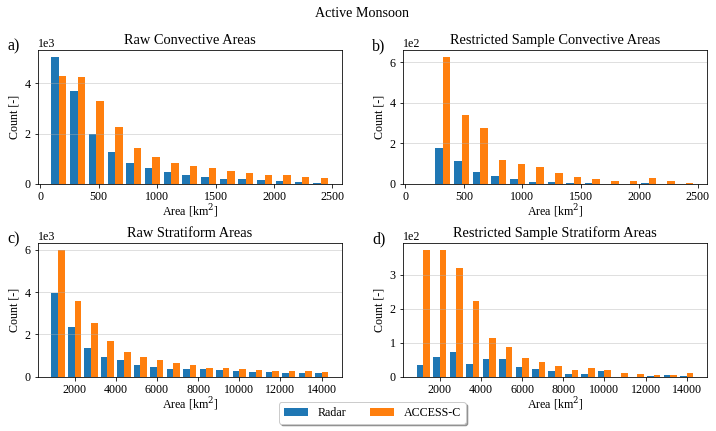

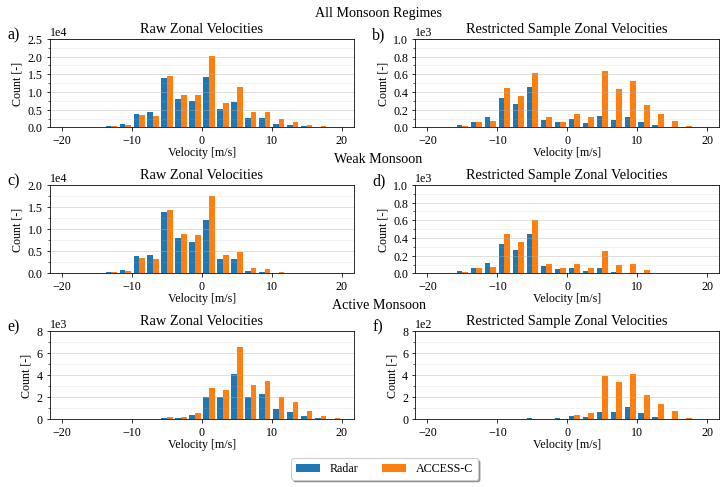

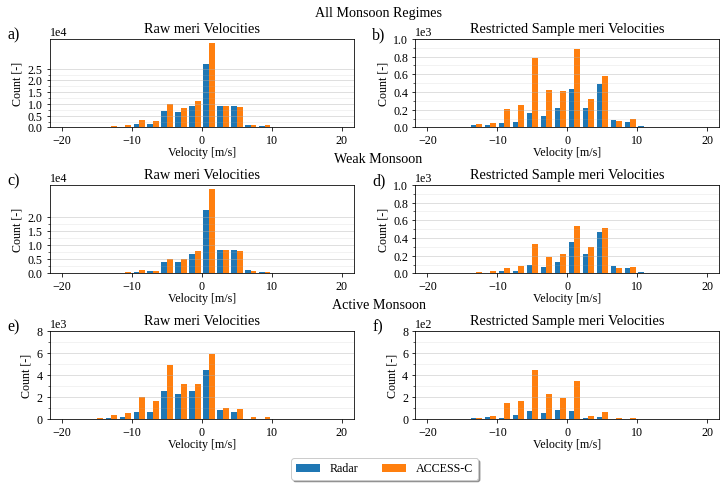

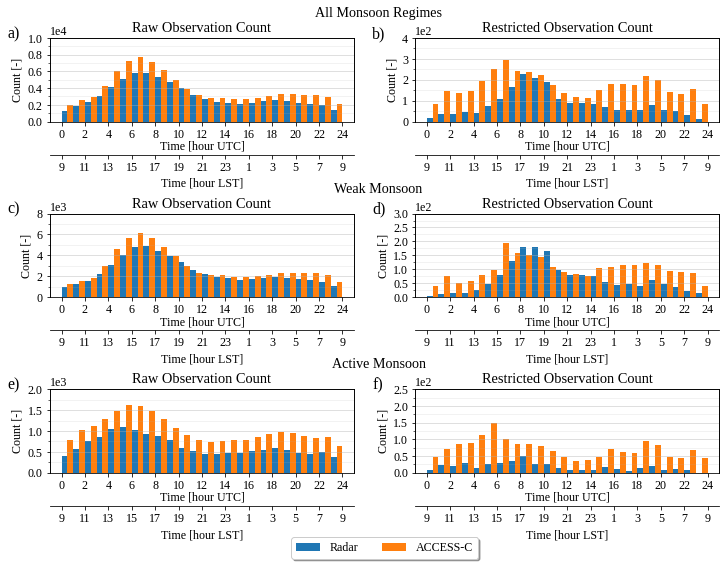

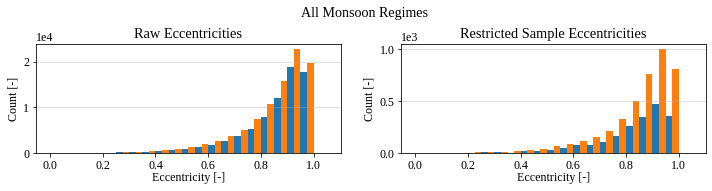

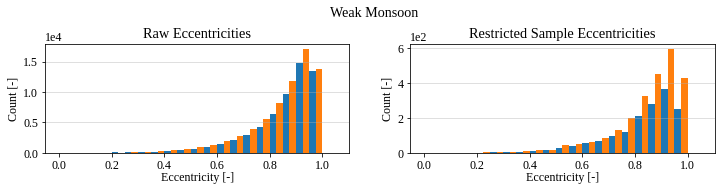

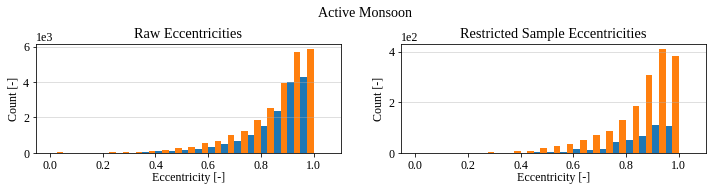

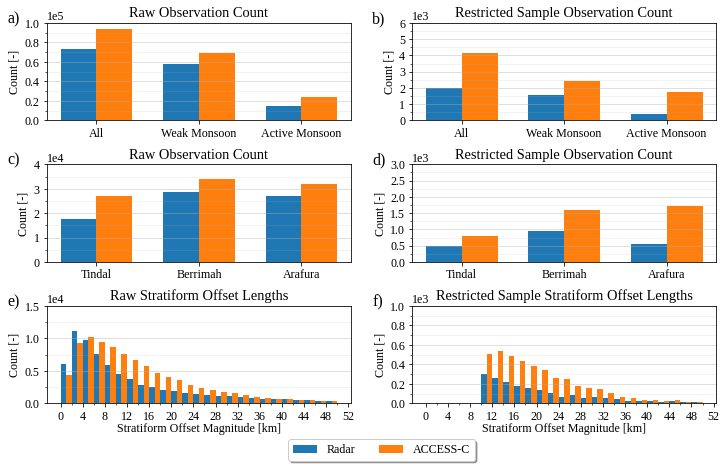

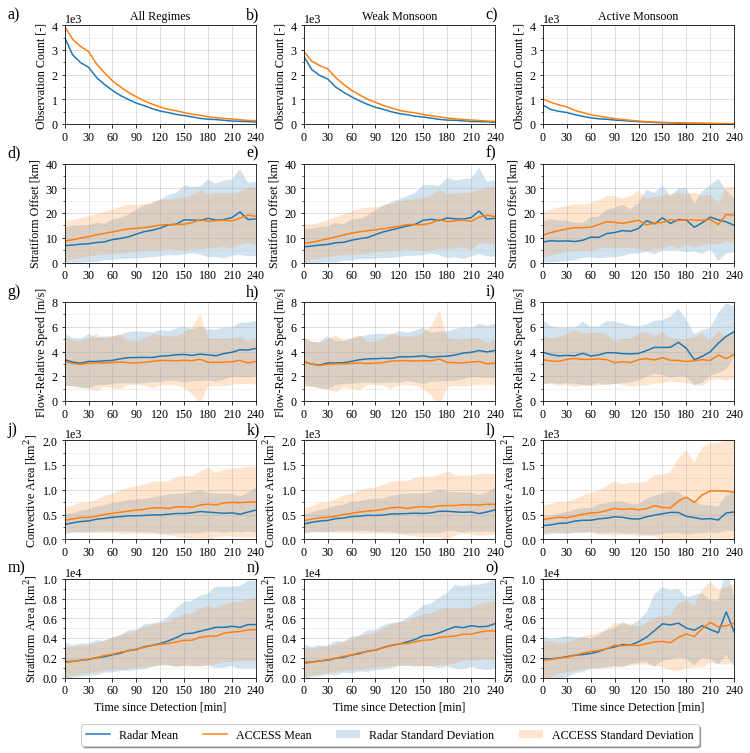

In [76]:
# for i in range(len(tracks_dir)):
for i in [9, 10]:

    save_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_tracks/ACCESS_radar_' + tracks_dir[i] + '/'
    save_dir_alt = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_tracks/ACCESS_radar_' + test_names[i]
    fig_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures/ACCESS_radar_' + test_names[i]
    suff = fig_dir.split('/')[-2][13:]

    if not os.path.exists(save_dir_alt):
        os.makedirs(save_dir)
        print('Creating new directory.')

    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
        print('Creating new directory.')

    all_ACCESS = bs.get_all_and_QC_ACCESS_stats(
        save_dir, class_thresh=class_threshes[i], 
        excl_thresh=excl_threshes[i], exclusions=exclusion_lists[i])
    all_radar = bs.get_all_and_QC_radar_stats(
        save_dir, class_thresh=class_threshes[i], 
        excl_thresh=excl_threshes[i], exclusions=exclusion_lists[i])
    time_series_all = bs.get_all_time_series(
        save_dir, class_thresh=class_threshes[i], 
        excl_thresh=excl_threshes[i], exclusions=None)
    all_obs_regional = bs.get_all_regional(
        save_dir, class_thresh=class_threshes[i], excl_thresh=excl_threshes[i],
        exclusions=exclusion_lists[i])
    
    with open(save_dir_alt + '/ACCESS_bs.pkl', 'wb') as f:
        pickle.dump(all_ACCESS, f)
    with open(save_dir_alt + '/radar_bs.pkl', 'wb') as f:
        pickle.dump(all_radar, f)
    with open(save_dir_alt + '/time_series_bs.pkl', 'wb') as f:
        pickle.dump(time_series_all, f)
    with open(save_dir_alt + '/regional_bs.pkl', 'wb') as f:
        pickle.dump(all_obs_regional, f)

    [
        all_obs_radar, QC_obs_radar, all_obs_weak_radar, QC_obs_weak_radar,
        all_obs_active_radar, QC_obs_active_radar] = all_radar

    [
        all_obs_ACCESS, QC_obs_ACCESS, all_obs_weak_ACCESS, QC_obs_weak_ACCESS,
        all_obs_active_ACCESS, QC_obs_active_ACCESS] = all_ACCESS

    [
        time_series_radar, time_series_weak_radar, time_series_active_radar,
        time_series_ACCESS, time_series_weak_ACCESS, time_series_active_ACCESS] = time_series_all

    [
        all_obs_ACCESS_42, QC_obs_ACCESS_42, all_obs_ACCESS_63, QC_obs_ACCESS_63,
        all_obs_ACCESS_77, QC_obs_ACCESS_77, all_obs_radar_42, QC_obs_radar_42, 
        all_obs_radar_63, QC_obs_radar_63, all_obs_radar_77, QC_obs_radar_77] = all_obs_regional

    bs.compare_all_sizes(all_radar, all_ACCESS, fig_dir, suff)
    bs.plot_all_velocities(all_radar, all_ACCESS, fig_dir, suff)
    bs.plot_all_diurnal(all_radar, all_ACCESS, fig_dir, suff)
    bs.plot_all_eccentricities(all_radar, all_ACCESS, fig_dir, suff)
    bs.plot_regional_seasonal_and_so(all_obs_regional, all_radar, all_ACCESS, fig_dir, suff)
    bs.plot_all_time_series(time_series_all, fig_dir, suff)

In [4]:
suff = 'base_density'

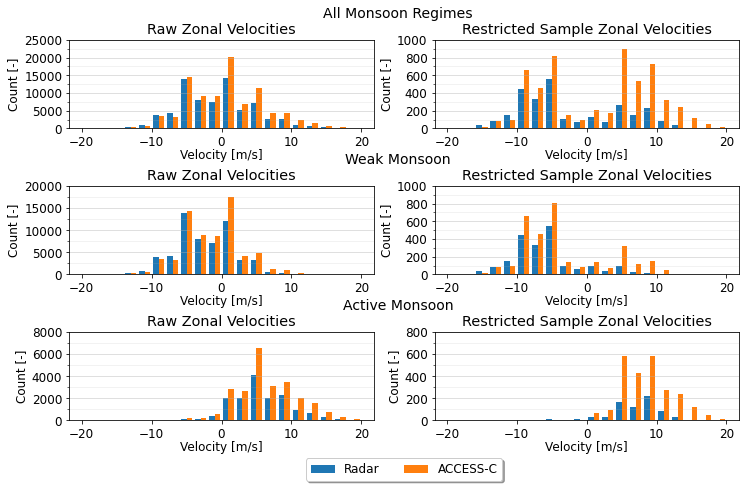

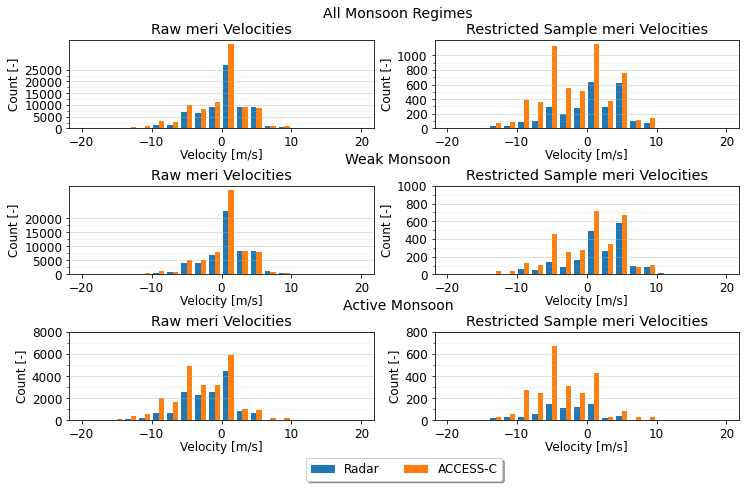

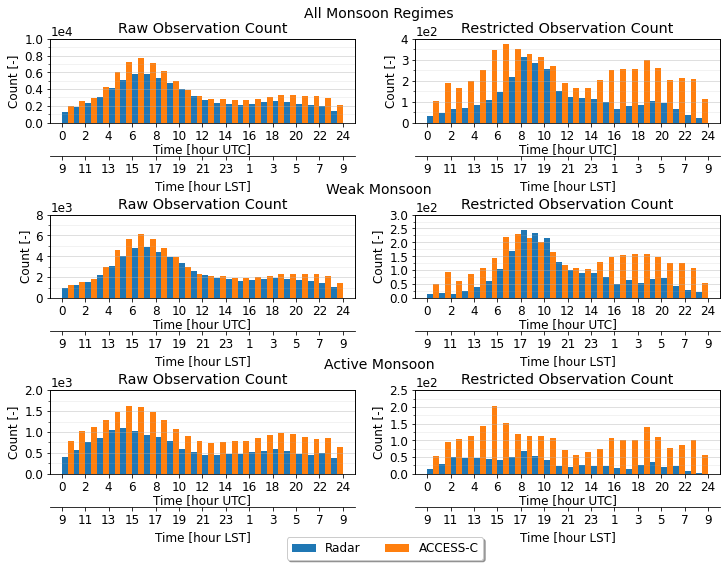

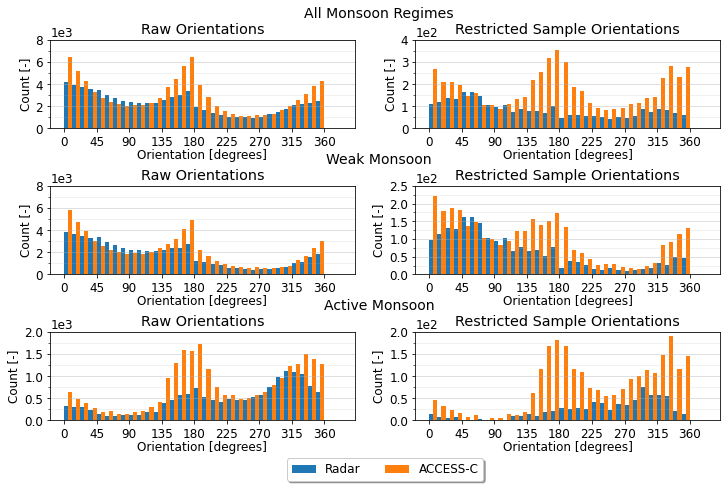

In [27]:
density = False
subplot_labels = False

# bs.compare_all_sizes(all_radar, all_ACCESS, fig_dir, suff, density=density)
bs.plot_all_velocities(all_radar, all_ACCESS, fig_dir, suff, density=density, subplot_labels=subplot_labels)
bs.plot_all_diurnal(all_radar, all_ACCESS, fig_dir, suff, density=density, subplot_labels=subplot_labels)
bs.plot_all_orientations(all_radar, all_ACCESS, fig_dir, suff, density=density, subplot_labels=subplot_labels)
# bs.plot_all_eccentricities(all_radar, all_ACCESS, fig_dir, suff, density=density)
# bs.plot_regional_seasonal_and_so(all_obs_regional, all_radar, all_ACCESS, fig_dir, suff, density=density)
# bs.plot_all_time_series(time_series_all, fig_dir, suff)

Radar 42, year 2020.
Calculating system tracks.
Restricting to hour UTC < 12
Radar 42, year 2021.
Calculating system tracks.
Restricting to hour UTC < 12
Radar 63, year 2020.
Calculating system tracks.
Restricting to hour UTC < 12
Radar 63, year 2021.
Calculating system tracks.
Restricting to hour UTC < 12
Radar 77, year 2020.
Calculating system tracks.
Restricting to hour UTC < 12
Radar 77, year 2021.
Calculating system tracks.
Restricting to hour UTC < 12
Radar 42, year 2020.
Calculating system tracks.
Restricting to hour UTC < 12
Radar 42, year 2021.
Calculating system tracks.
Restricting to hour UTC < 12
Radar 63, year 2020.
Calculating system tracks.
Restricting to hour UTC < 12
Radar 63, year 2021.
Calculating system tracks.
Restricting to hour UTC < 12
Radar 77, year 2020.
Calculating system tracks.
Restricting to hour UTC < 12
Radar 77, year 2021.
Calculating system tracks.
Restricting to hour UTC < 12
Radar 42, year 2020.
Calculating system tracks.
Restricting to hour UTC < 12

Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Radar 63, year 2020.
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Radar 63, year 2021.
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calcul

Calculating system tracks.
Restricting to hour UTC < 12
No included observations.
Calculating system tracks.
Restricting to hour UTC < 12
No included observations.
Calculating system tracks.
Restricting to hour UTC < 12
No included observations.
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
No included observations.
Calculating system tracks.
Restricting to hour UTC < 12
No included observations.
Radar 63, year 2020.
Calculating system tracks.
Restricting to hour UTC < 12
No included observations.
Calculating system tracks.
Restricting to hour UTC < 12
No included observations.
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
No included observations.
Calculating system tracks.
Restricting to h

Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Radar 63, year 2020.
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Radar 63, year 2021.
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restri

Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Radar 77, year 2020.
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
No included observations.
Radar 77, year 2021.
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricting to hour UTC < 12
Calculating system tracks.
Restricti

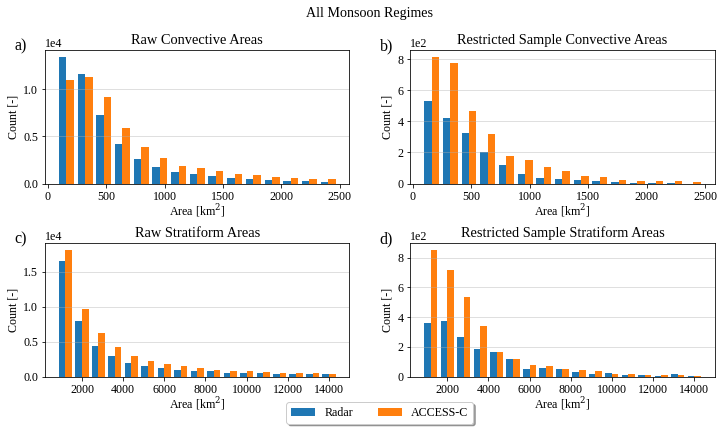

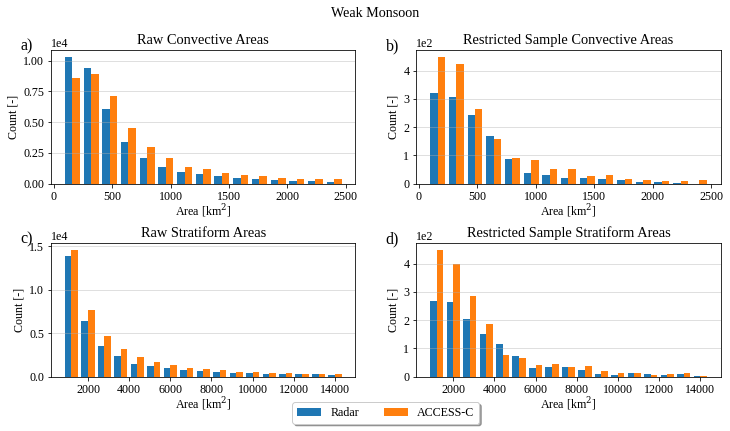

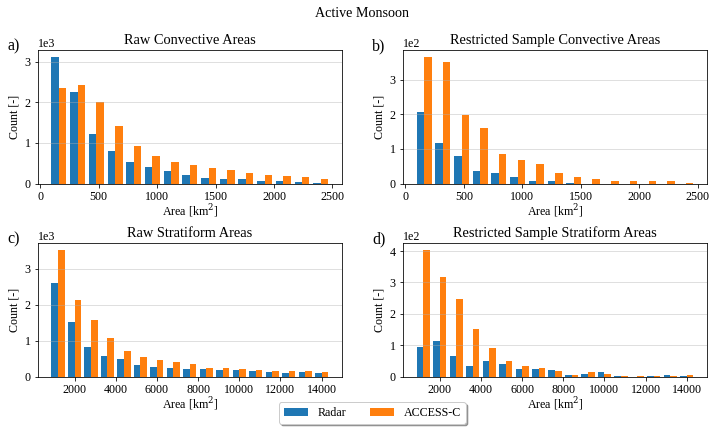

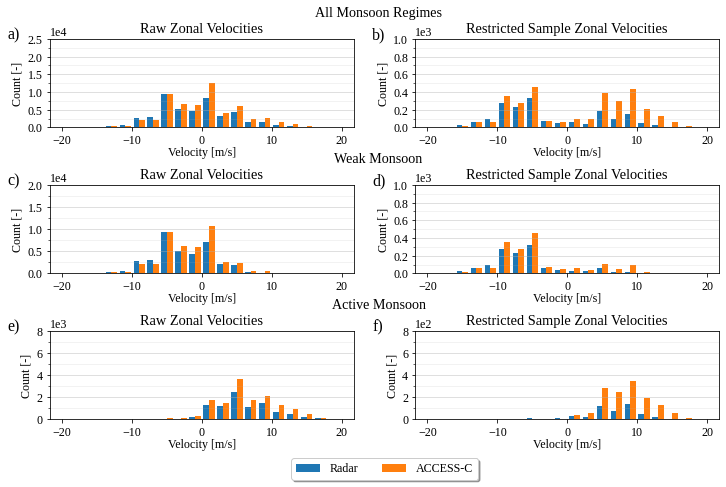

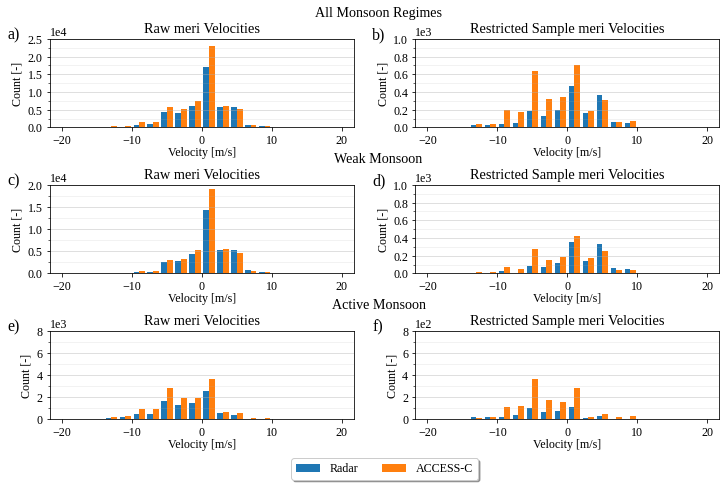

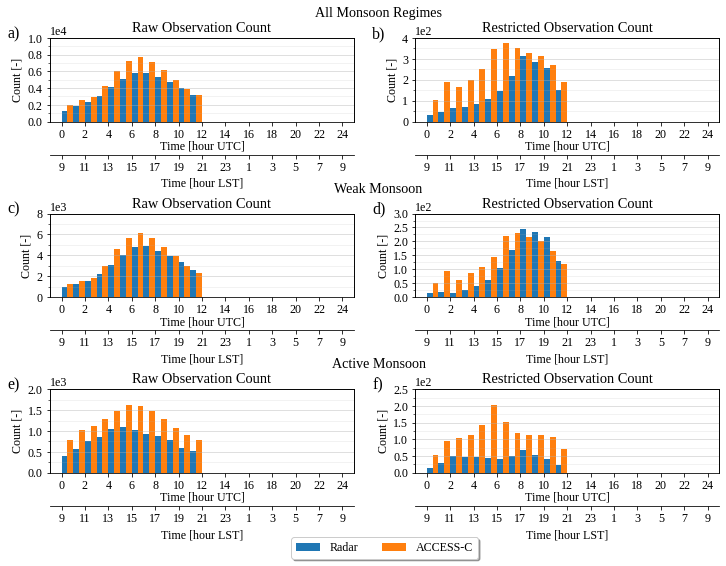

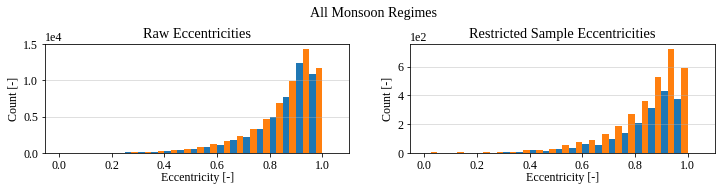

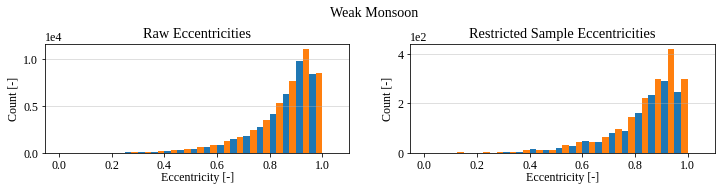

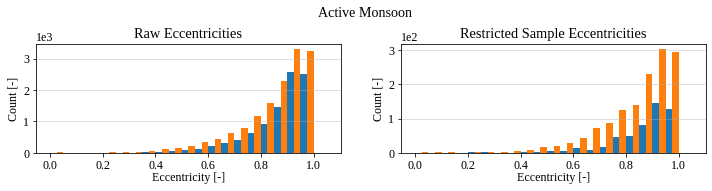

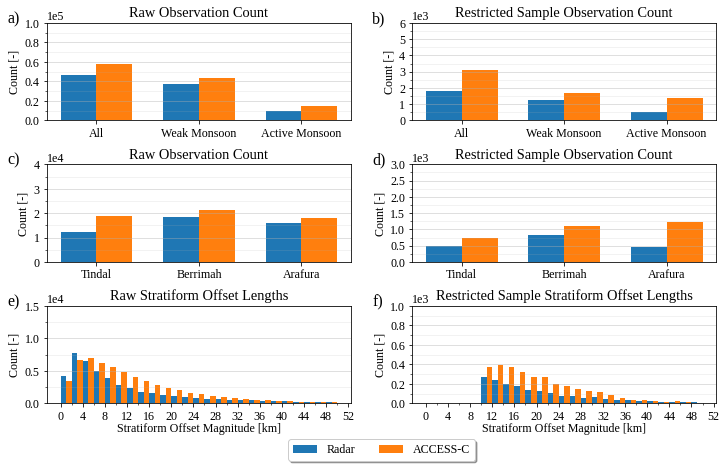

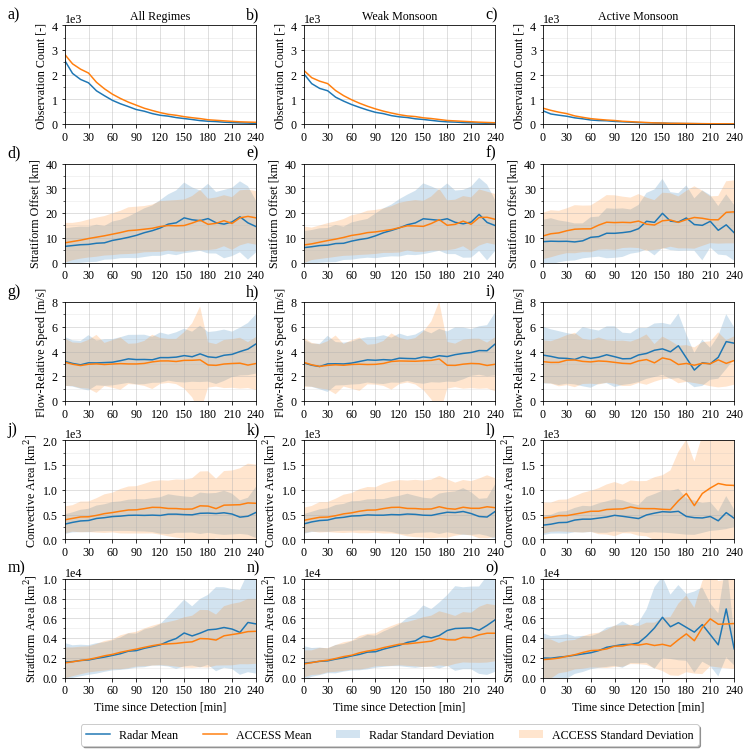

In [11]:
save_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_tracks/ACCESS_radar_base/'
save_dir_alt = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_tracks/ACCESS_radar_morning_only/'
fig_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures/ACCESS_radar_morning_only/'
suff = fig_dir.split('/')[-2][13:]

if not os.path.exists(save_dir_alt):
    os.makedirs(save_dir)
    print('Creating new directory.')

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print('Creating new directory.')

all_ACCESS = bs.get_all_and_QC_ACCESS_stats(
    save_dir, class_thresh=None, 
    excl_thresh=None, exclusions=None, morning_only=True)
all_radar = bs.get_all_and_QC_radar_stats(
    save_dir, class_thresh=None, morning_only=True,
    excl_thresh=None, exclusions=None)
time_series_all = bs.get_all_time_series(
    save_dir, class_thresh=None, 
    excl_thresh=None, exclusions=None, morning_only=True)
all_obs_regional = bs.get_all_regional(
    save_dir, class_thresh=None, excl_thresh=None,
    exclusions=None, morning_only=True)

with open(save_dir_alt + '/ACCESS_bs.pkl', 'wb') as f:
    pickle.dump(all_ACCESS, f)
with open(save_dir_alt + '/radar_bs.pkl', 'wb') as f:
    pickle.dump(all_radar, f)
with open(save_dir_alt + '/time_series_bs.pkl', 'wb') as f:
    pickle.dump(time_series_all, f)
with open(save_dir_alt + '/regional_bs.pkl', 'wb') as f:
    pickle.dump(all_obs_regional, f)

[
    all_obs_radar, QC_obs_radar, all_obs_weak_radar, QC_obs_weak_radar,
    all_obs_active_radar, QC_obs_active_radar] = all_radar

[
    all_obs_ACCESS, QC_obs_ACCESS, all_obs_weak_ACCESS, QC_obs_weak_ACCESS,
    all_obs_active_ACCESS, QC_obs_active_ACCESS] = all_ACCESS

[
    time_series_radar, time_series_weak_radar, time_series_active_radar,
    time_series_ACCESS, time_series_weak_ACCESS, time_series_active_ACCESS] = time_series_all

[
    all_obs_ACCESS_42, QC_obs_ACCESS_42, all_obs_ACCESS_63, QC_obs_ACCESS_63,
    all_obs_ACCESS_77, QC_obs_ACCESS_77, all_obs_radar_42, QC_obs_radar_42, 
    all_obs_radar_63, QC_obs_radar_63, all_obs_radar_77, QC_obs_radar_77] = all_obs_regional

bs.compare_all_sizes(all_radar, all_ACCESS, fig_dir, suff)
bs.plot_all_velocities(all_radar, all_ACCESS, fig_dir, suff)
bs.plot_all_diurnal(all_radar, all_ACCESS, fig_dir, suff)
bs.plot_all_eccentricities(all_radar, all_ACCESS, fig_dir, suff)
bs.plot_regional_seasonal_and_so(all_obs_regional, all_radar, all_ACCESS, fig_dir, suff)
bs.plot_all_time_series(time_series_all, fig_dir, suff)

In [62]:
test_names += ['morning_only']

In [18]:
# save_dir_alt = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_tracks/ACCESS_radar_base/'

with open(save_dir + '/ACCESS_bs.pkl', 'rb') as f:
    all_ACCESS = pickle.load(f)

with open(save_dir + '/radar_bs.pkl', 'rb') as f:
    all_radar = pickle.load(f)
    
with open(save_dir + '/time_series_bs.pkl', 'rb') as f:
    time_series_all = pickle.load(f)
    
with open(save_dir + '/regional_bs.pkl', 'rb') as f:
    all_obs_regional = pickle.load(f)

In [15]:
save_dir

'/home/student.unimelb.edu.au/shorte1/Documents/TINT_tracks/ACCESS_radar_base/'

In [171]:
aa = all_ACCESS[0][3]

In [172]:
bb = all_radar[0][3]

In [173]:
aa/bb

1.2722769575066182

In [108]:
large_vel_radar_raw = []
large_vel_radar_res = []
large_vel_ACCESS_raw = []
large_vel_ACCESS_res = []

orientation_radar_raw = []
orientation_radar_res = []
orientation_ACCESS_raw = []
orientation_ACCESS_res = []

for i in range(len(test_names)):
    
    print('Getting test {}.'.format(test_names[i]))

    save_dir_alt = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_tracks/ACCESS_radar_' + test_names[i] + '/'

    with open(save_dir_alt + 'ACCESS_bs.pkl', 'rb') as f:
        all_ACCESS = pickle.load(f)

    with open(save_dir_alt + 'radar_bs.pkl', 'rb') as f:
        all_radar = pickle.load(f)

    [
        all_obs_radar, QC_obs_radar, all_obs_weak_radar, QC_obs_weak_radar,
        all_obs_active_radar, QC_obs_active_radar] = all_radar

    [
        all_obs_ACCESS, QC_obs_ACCESS, all_obs_weak_ACCESS, QC_obs_weak_ACCESS,
        all_obs_active_ACCESS, QC_obs_active_ACCESS] = all_ACCESS

    vel_radar_all = np.array(all_obs_active_radar[5])
    vel_ACCESS_all = np.array(all_obs_active_ACCESS[5])

    vel_radar_QC = np.array(QC_obs_active_radar[5])
    vel_ACCESS_QC = np.array(QC_obs_active_ACCESS[5])
    
    ori_radar_all = np.array(all_obs_active_radar[7])
    ori_ACCESS_all = np.array(all_obs_active_ACCESS[7])

    ori_radar_QC = np.array(QC_obs_active_radar[7])
    ori_ACCESS_QC = np.array(QC_obs_active_ACCESS[7])

    large_vel_radar_raw.append(
        len(vel_radar_all[vel_radar_all > 12])/len(vel_radar_all))
    large_vel_radar_res.append(
        len(vel_radar_QC[vel_radar_QC > 12])/len(vel_radar_QC))
    large_vel_ACCESS_raw.append(
        len(vel_ACCESS_all[vel_ACCESS_all > 12])/len(vel_ACCESS_all))
    large_vel_ACCESS_res.append(
        len(vel_ACCESS_QC[vel_ACCESS_QC > 12])/len(vel_ACCESS_QC))
    
    cond1 = (ori_radar_all > 340)*(ori_radar_all < 20)
    cond1 += (ori_radar_all > 160)*(ori_radar_all < 200)
    
    cond2 = (ori_ACCESS_all > 340)*(ori_ACCESS_all < 20)
    cond2 += (ori_ACCESS_all > 160)*(ori_ACCESS_all < 200)
    
    cond3 = (ori_radar_QC > 340)*(ori_radar_QC < 20)
    cond3 += (ori_radar_QC > 160)*(ori_radar_QC < 200)
    
    cond4 = (ori_ACCESS_QC > 340)*(ori_ACCESS_QC < 20)
    cond4 += (ori_ACCESS_QC > 160)*(ori_ACCESS_QC < 200)
    
    orientation_radar_raw.append(
        len(ori_radar_all[cond1])/len(ori_radar_all))
    orientation_ACCESS_raw.append(
        len(ori_ACCESS_all[cond2])/len(ori_ACCESS_all))
    orientation_radar_res.append(
        len(ori_radar_QC[cond3])/len(ori_radar_QC))
    orientation_ACCESS_res.append(
        len(ori_ACCESS_QC[cond4])/len(ori_ACCESS_QC))

Getting test base.
Getting test ambient_swapped.
Getting test ambient_swapped_lower_wind_level.
Getting test lower_wind_level.
Getting test higher_wind_level.
Getting test no_steiner.
Getting test lower_ref_thresh.
Getting test higher_offset_thresh.
Getting test higher_border_thresh.
Getting test higher_area_thresh.
Getting test higher_conv_area_thresh.
Getting test linear_50.
Getting test linear_25.
Getting test combined_sensitivity.


In [105]:
all_obs_ACCESS[7]

[233.625,
 221.046,
 214.857,
 50.392,
 165.557,
 174.416,
 170.249,
 183.46,
 191.18,
 187.807,
 205.575,
 211.708,
 212.949,
 227.823,
 109.755,
 268.772,
 100.324,
 271.736,
 275.769,
 106.891,
 164.618,
 171.084,
 178.221,
 177.623,
 144.558,
 139.465,
 154.158,
 129.557,
 159.938,
 162.316,
 188.364,
 174.395,
 137.117,
 122.48,
 125.192,
 149.535,
 139.68,
 140.417,
 140.698,
 143.977,
 142.404,
 145.956,
 159.091,
 154.907,
 148.899,
 148.061,
 133.519,
 124.36,
 123.272,
 124.452,
 124.505,
 124.101,
 303.674,
 124.166,
 124.282,
 124.643,
 124.059,
 123.695,
 124.474,
 124.521,
 123.5,
 123.528,
 126.372,
 156.309,
 158.231,
 154.618,
 154.289,
 154.458,
 153.986,
 154.601,
 155.207,
 154.915,
 153.849,
 153.614,
 148.304,
 148.455,
 156.541,
 244.563,
 199.41,
 241.473,
 303.484,
 292.966,
 117.656,
 294.704,
 296.099,
 109.333,
 291.124,
 183.471,
 291.875,
 166.119,
 291.593,
 180.463,
 288.506,
 331.64,
 288.617,
 125.106,
 285.151,
 286.467,
 285.238,
 284.537,
 288.19,
 

In [107]:
True*True

1

In [96]:
large_vel_radar_raw[0]

0.07054593004249755

In [97]:
large_vel_ACCESS_raw[0]

0.11211092478219968

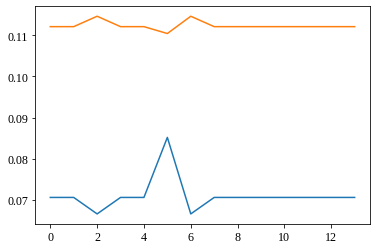

In [109]:
plt.plot(np.array(large_vel_radar_raw))
plt.plot(np.array(large_vel_ACCESS_raw))

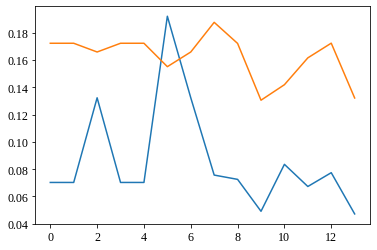

In [174]:
plt.plot(np.array(large_vel_radar_res))
plt.plot(np.array(large_vel_ACCESS_res))

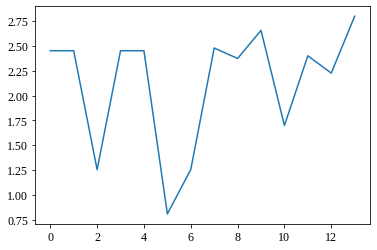

In [175]:
plt.plot(np.array(large_vel_ACCESS_res)/np.array(large_vel_radar_res))

In [132]:
max(np.array(large_vel_radar_raw)-np.array(large_vel_ACCESS_raw))

-0.025285999226158

In [126]:
print(orientation_radar_raw[5])
print(orientation_ACCESS_raw[5])

0.13898080741230973
0.22336535179677214


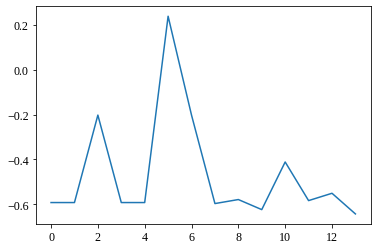

In [134]:
plt.plot((np.array(large_vel_radar_res)-np.array(large_vel_ACCESS_res))/np.array(large_vel_ACCESS_res))

In [128]:
min(np.array(large_vel_radar_res)-np.array(large_vel_ACCESS_res))

-0.11186710324287327

In [121]:
cond = np.arange(len(large_vel_radar_res))!=5

In [125]:
print(min(np.array(large_vel_radar_res)[cond]), max(np.array(large_vel_radar_res)[cond]))
print(min(np.array(large_vel_ACCESS_res)[cond]), max(np.array(large_vel_ACCESS_res)[cond]))

0.04722222222222222 0.13227513227513227
0.13050847457627118 0.18754277891854895


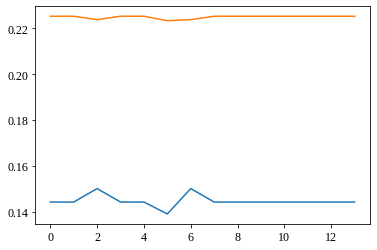

In [112]:
plt.plot(np.array(orientation_radar_raw))
plt.plot(np.array(orientation_ACCESS_raw))

In [116]:
print(orientation_radar_raw[0])
print(orientation_ACCESS_raw[0])

0.14416475972540047
0.22532618921019265


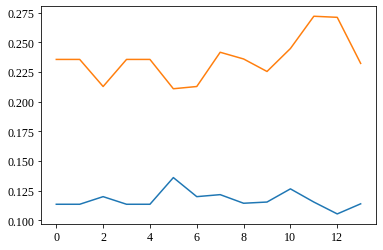

In [113]:
plt.plot(np.array(orientation_radar_res))
plt.plot(np.array(orientation_ACCESS_res))

In [118]:
print(min(orientation_radar_res), max(orientation_radar_res))
print(min(orientation_ACCESS_res), max(orientation_ACCESS_res))

0.1053763440860215 0.136
0.2108641975308642 0.27197149643705465


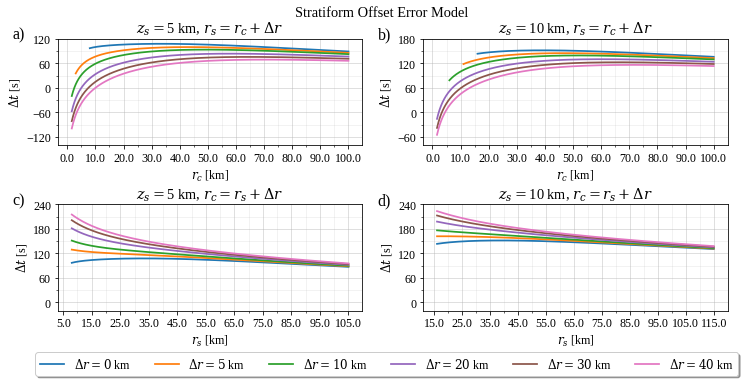

In [304]:
fig, ax = plt.subplots(2, 2, figsize=(12, 5))

bs.gen_error_model_plot(
    z_s=5000, fig=fig, ax=ax.flatten()[0], t_min=-120, t_max=120, 
    r_min=0, r_max=100e3, dr=10e3)
bs.gen_error_model_plot(
    z_s=10000, fig=fig, ax=ax.flatten()[1], t_min=-60, t_max=180, 
    r_min=0, r_max=100e3, dr=10e3)
bs.gen_error_model_plot(
    z_s=5000, fig=fig, ax=ax.flatten()[2], 
    closest='stratiform', t_max=240, r_min=5e3, r_max=105e3, dr=10e3)
bs.gen_error_model_plot(
    z_s=10000, fig=fig, ax=ax.flatten()[3], closest='stratiform', 
    t_max=240, r_min=15e3, r_max=115e3, dr=10e3)

# lines, labels = ax[0].get_legend_handles_labels()
# lines = [lines[i] for i in [0, 3, 1, 4, 2]]
# labels = [labels[i] for i in [0, 3, 1, 4, 2]]

ax.flatten()[2].legend(
    loc='lower center',
    bbox_to_anchor=(1.08, -.67),
    ncol=6, fancybox=True, shadow=True)

plt.subplots_adjust(hspace=.56)

plt.suptitle('Stratiform Offset Error Model', y=.97)

cl.make_subplot_labels(ax.flatten(), x_shift=-.15)

plt.savefig(
    fig_dir + '/error_model.png',
    dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')

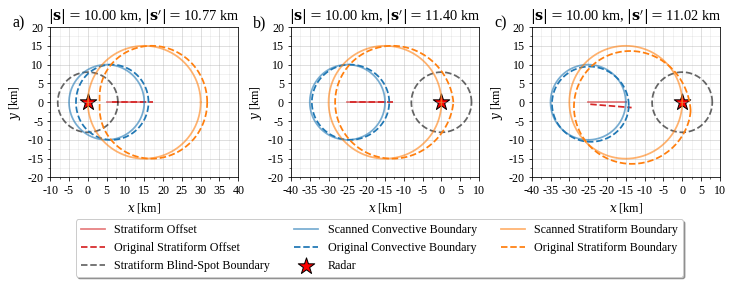

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

z_s = 5e3

# row 1
bs.plot_deformation(
    fig=fig, ax=ax[0], u=-10, v=0, strat_centroid_x=15e3, 
    conv_centroid_x=5e3, 
    conv_radius=10e3, strat_radius=15e3, tau=252, 
    extent=[-10e3, 40e3, -20e3, 20e3], dx=5e3, z_s=z_s)

bs.plot_deformation(
    fig=fig, ax=ax[1], u=-10, v=0, strat_centroid_x=-15e3, 
    conv_centroid_x=-25e3, conv_radius=10e3, strat_radius=15e3, 
    tau=252, extent=[-40e3, 10e3, -20e3, 20e3], dx=5e3, z_s=z_s)

bs.plot_deformation(
    fig=fig, ax=ax[2], u=-np.sqrt(1/2)*10, v=np.sqrt(1/2)*10, 
    strat_centroid_x=-15e3, conv_centroid_x=-25e3, conv_radius=10e3, 
    strat_radius=15e3, tau=252, extent=[-40e3, 10e3, -20e3, 20e3], 
    dx=5e3, z_s=z_s)

for i in range(len(ax.flatten())):
    ax.flatten()[i].set_aspect('equal')
    
lines, labels = ax[0].get_legend_handles_labels()
lines = [lines[i] for i in [0, 1, 2, 3, 4, 7, 5, 6]]
labels = [labels[i] for i in [0, 1, 2, 3, 4, 7, 5, 6]]

ax[0].legend(
    lines, labels,
    loc='lower center',
    bbox_to_anchor=(1.75, -.7),
    ncol=3, fancybox=True, shadow=True)

cl.make_subplot_labels(ax.flatten(), x_shift=-.2)
plt.subplots_adjust(wspace=.28)

plt.savefig(
    fig_dir + '/deformation.png',
    dpi=200, facecolor='w', edgecolor='white', 
    bbox_inches='tight')

In [15]:
x_range = np.arange(-100e3, 101e3, 1e3)
conv_radius = 10e3
strat_radius = 15e3

so_list = [10e3, 10e3, 10e3, 30e3, 10e3, 10e3]
u_list = [-10, -10, -np.sqrt(1/2)*10, -10, -10, -10]
v_list = [0, 0, np.sqrt(1/2)*10, 0, 0, 0]
conv_centroid_y = [0, 20e3, 0, 0, 0, 0]
strat_centroid_y = [0, 20e3, 0, 0, 0, 0]
conv_radius = [10e3, 10e3, 10e3, 10e3, 20e3, 10e3]
strat_radius = [15e3, 15e3, 15e3, 15e3, 15e3, 30e3]

labels = [
    r'Baseline', r'$y$ Displacement', r'Non-Parallel',
    r'$|\mathrm{\mathbf{s}}|=$ 30 km', r'Larger Convective Area', 
    r'Larger Stratiform Area']

In [16]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors = [colors[i] for i in [0, 1, 2, 4, 5, 6]]

In [17]:
offsets = [np.zeros(len(x_range)) for i in range(len(so_list))]

for k in range(len(so_list)):
    for i in range(len(x_range)):
        offset = bs.plot_deformation(
            u=u_list[k], v=v_list[k], 
            strat_centroid_x=x_range[i], 
            conv_centroid_x=(x_range[i]+so_list[k]),
            conv_radius=conv_radius[k], strat_radius=strat_radius[k],
            conv_centroid_y=conv_centroid_y[k],
            strat_centroid_y=strat_centroid_y[k],
            tau=300, plot=False)
        offsets[k][i] = offset
        plt.close('all')

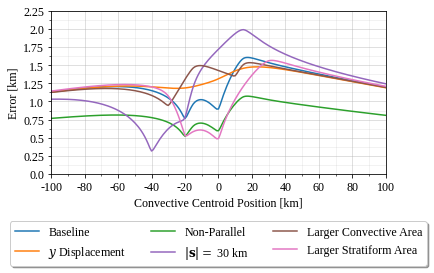

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

# for so in list(set(so_list))[:-1]:
#     ax.plot(
#         x_range, so*np.ones_like(x_range),  '--', color='grey')
# ax.plot(
#     x_range, np.zeros_like(x_range),  '--', color='grey')

extent = [-100e3, 100e3, 0, 2.25e3]
dx = 20e3
dy = .25e3

for k in range(len(so_list)):

    ax.plot(
        x_range, so_list[k]-offsets[k], color=colors[k], label=labels[k])

ax.set_xlim([extent[0], extent[1]])
ax.set_ylim([extent[2], extent[3]])
ax.set_xticks(np.arange(extent[0], extent[1]+dx, dx))
ax.set_xticks(
    np.arange(extent[0], extent[1]+dx/2, dx/2), minor=True)
ax.set_xticklabels(
    (np.arange(extent[0], extent[1]+dx, dx)/1e3).astype(int))
ax.set_yticks(np.arange(extent[2], extent[3]+dy, dy))
ax.set_yticks(
    np.arange(extent[2], extent[3]+dy/2, dy/2), minor=True)
ax.set_yticklabels(
    (np.arange(extent[2], extent[3]+dy, dy)/1e3).round(2))

ax.grid(which='minor', alpha=0.2, axis='both')
ax.grid(which='major', alpha=0.5, axis='both')
ax.set_xlabel(r'Convective Centroid Position [km]')
ax.set_ylabel(r"Error [km]")
    
ax.legend(
    loc='lower center',
    bbox_to_anchor=(.5, -.6),
    ncol=3, fancybox=True, shadow=True)

plt.savefig(
    fig_dir + '/so_error.png',
    dpi=200, facecolor='w', edgecolor='white', 
    bbox_inches='tight')

In [107]:
ACCESS_dicts = td.shear_versus_orientation_ACCESS()

Getting data for radar 42, year 2020.
Getting data for radar 63, year 2020.
Getting data for radar 77, year 2020.
Getting data for radar 42, year 2021.
Getting data for radar 63, year 2021.
Getting data for radar 77, year 2021.


In [108]:
radar_dicts = td.shear_versus_orientation_radar()

Getting data for radar 42, year 2020, month 10.
Getting data for radar 42, year 2020, month 11.
Getting data for radar 42, year 2020, month 12.
Getting data for radar 42, year 2021, month 1.
Getting data for radar 42, year 2021, month 2.
Getting data for radar 42, year 2021, month 3.
Getting data for radar 42, year 2021, month 4.
No systems.
Getting data for radar 63, year 2020, month 10.
Getting data for radar 63, year 2020, month 11.
Getting data for radar 63, year 2020, month 12.
Getting data for radar 63, year 2021, month 1.
Getting data for radar 63, year 2021, month 2.
Getting data for radar 63, year 2021, month 3.
Getting data for radar 63, year 2021, month 4.
Getting data for radar 77, year 2020, month 10.
Getting data for radar 77, year 2020, month 11.
Getting data for radar 77, year 2020, month 12.
Getting data for radar 77, year 2021, month 1.
Getting data for radar 77, year 2021, month 2.
Getting data for radar 77, year 2021, month 3.
Getting data for radar 77, year 2021, m

[1.0, 1.0, 1.0, 1.0]

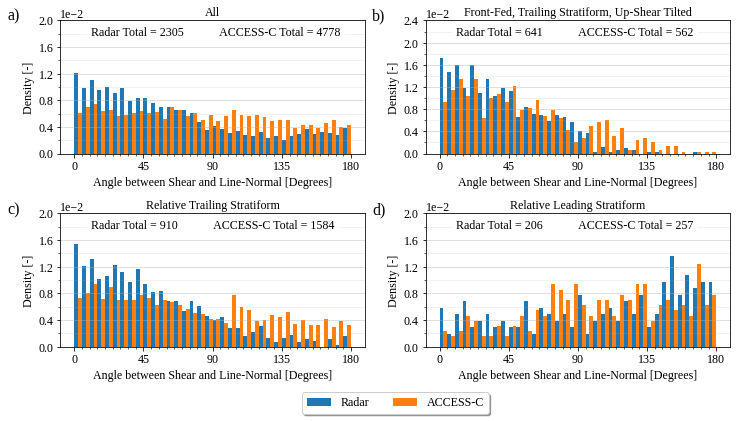

In [115]:
titles = [
    'All', 'Front-Fed, Trailing Stratiform, Up-Shear Tilted', 
    'Relative Trailing Stratiform', 'Relative Leading Stratiform']
td.shear_angle_versus_orientation_hist_compare(radar_dicts, ACCESS_dicts, titles=titles)

[1.0, 1.0, 1.0, 1.0]

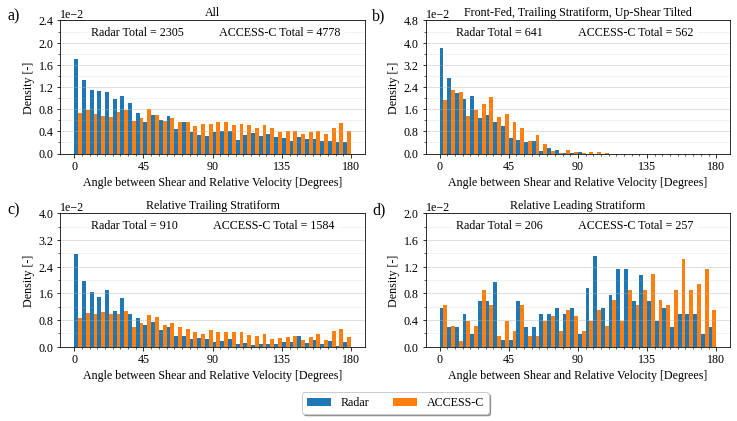

In [116]:
td.shear_angle_versus_propagation_hist_compare(radar_dicts, ACCESS_dicts, titles=titles)

In [23]:
all_excl_ACCESS = bs.count_ACCESS_exclusions(
    save_dir, regime=None, radars=radars, morning_only=morning_only)
all_excl_radar = bs.count_radar_exclusions(
    save_dir, regime=None, radars=radars, morning_only=morning_only)

weak_excl_ACCESS = bs.count_ACCESS_exclusions(
    save_dir, regime=1, radars=radars, morning_only=morning_only)
weak_excl_radar = bs.count_radar_exclusions(
    save_dir, regime=1, radars=radars, morning_only=morning_only)

active_excl_ACCESS = bs.count_ACCESS_exclusions(
    save_dir, regime=2, radars=radars, morning_only=morning_only)
active_excl_radar = bs.count_radar_exclusions(
    save_dir, regime=2, radars=radars, morning_only=morning_only)

TypeError: count_ACCESS_exclusions() got an unexpected keyword argument 'morning_only'

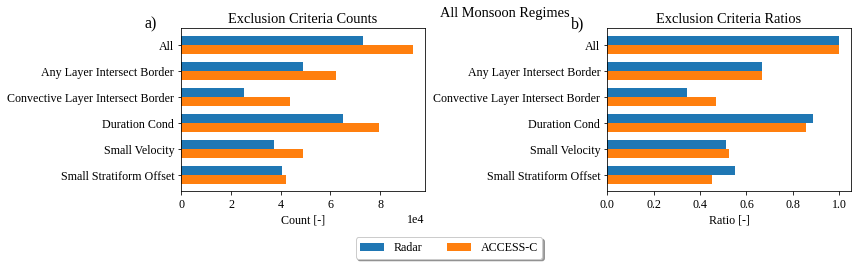

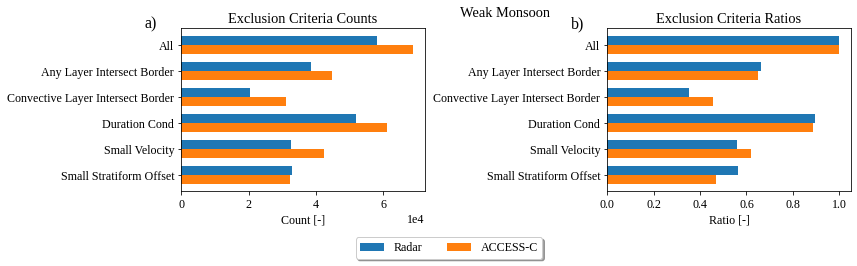

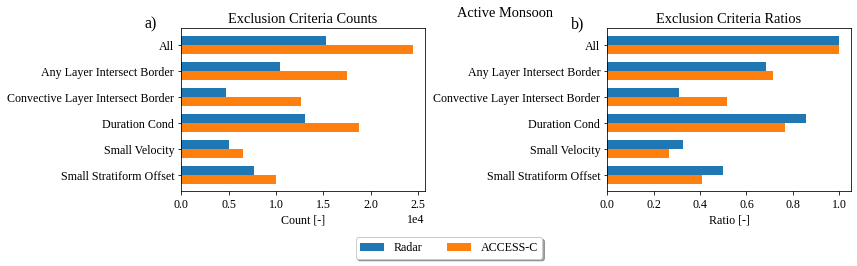

In [202]:
bs.compare_exclusions(all_excl_radar, all_excl_ACCESS, title='All Monsoon Regimes')
plt.savefig(
    fig_dir + 'excl_all_{}.png'.format(suff), dpi=200, facecolor='w',
    edgecolor='white', bbox_inches='tight')
bs.compare_exclusions(weak_excl_radar, weak_excl_ACCESS, title='Weak Monsoon')
plt.savefig(
    fig_dir + 'excl_weak_{}.png'.format(suff), dpi=200, facecolor='w',
    edgecolor='white', bbox_inches='tight')
bs.compare_exclusions(active_excl_radar, active_excl_ACCESS, title='Active Monsoon')
plt.savefig(
    fig_dir + 'excl_active_{}.png'.format(suff), dpi=200, facecolor='w',
    edgecolor='white', bbox_inches='tight')

In [2]:
import pyart


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [3]:
file_name = '/home/student.unimelb.edu.au/shorte1/Documents/radar_examples/77_20210101.pvol/77_20210101_000500.pvol.h5'
my_radar = pyart.aux_io.read_odim_h5(file_name, file_field_names=True)

In [12]:
time = my_radar.time['data']

In [13]:
elevation =  my_radar.elevation['data']

In [39]:
import matplotlib.pyplot as plt
import numpy as np

In [66]:
t

array([  0.,  33.,  64.,  86., 106., 127., 145., 163., 180., 198., 216.,
       234., 252.], dtype=float32)

In [42]:
elevation[2000]

4.7

In [77]:
el, ind = np.unique(elevation, return_index=True)
print(el, ind)

[ 0.5  0.8  1.4  2.4  3.5  4.7  6.   7.8 10.  13.  17.  23.  32. ] [   0  360  720 1080 1440 1800 2160 2520 2880 3240 3600 3960 4320]


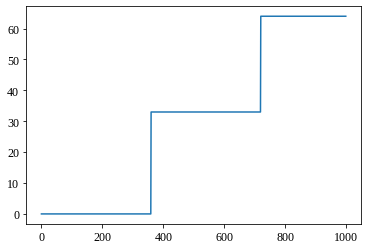

In [293]:
plt.plot(time[:1000])

In [294]:
time

array([  0.,   0.,   0., ..., 252., 252., 252.], dtype=float32)

In [291]:
el[-1]-el[-2]

9.0

In [292]:
t[-1]-t[-2]

18.0

In [232]:
# c = 62.5684116732685
c = 62.57
a = 31.5/np.sinh(252/c)
el_ap = a*np.sinh(t/c)+.5

In [288]:
a

1.1229544141076924

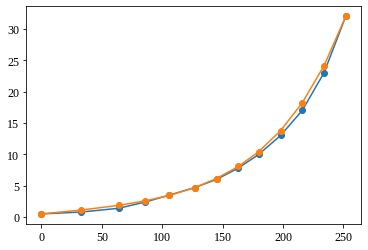

In [228]:
plt.plot(t, el, '-o')
# plt.plot(time, elevation, '-o')
# plt.plot(t, p(t))
# el_ap = np.sinh(t/61)+.5
plt.plot(t, el_ap, '-o')

In [219]:
el_ap

array([ 0.5      ,  0.8      ,  1.1998004,  1.6362213,  2.2203107,
        3.1303067,  4.2698827,  5.893951 ,  8.059732 , 11.303207 ,
       15.935074 , 22.550608 , 31.999998 ], dtype=float32)

In [224]:
el[5]

4.7

In [222]:
t[5]

127.0

In [193]:
t_ap = np.arcsinh((el-0.5))*61

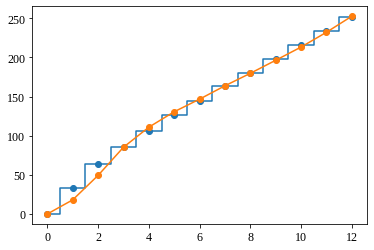

In [194]:
plt.step(t, '-o', where='mid')
plt.plot(t_ap, '-o')

In [195]:
np.max(np.abs(t[:-1]-t_ap[1:]))/252

0.09890965878236536

In [287]:
np.max(np.abs(el-el_ap))/32

0.037710726261138916

In [60]:
c = np.polyfit(t, el, 5)
# c[-1] = 0
p = np.poly1d(c)

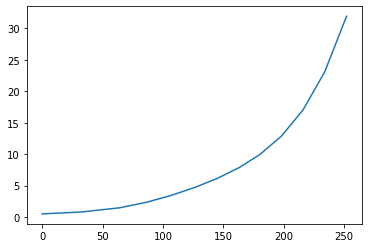

In [61]:
plt.plot(t, p(t))